<a href="https://colab.research.google.com/github/Sarnapa/Credit-Card-Fraud-Detection/blob/main/Notebooks/CreditCardFraudDetection_AnomalyDetectionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temat zadania: Analityczny - detekcja anomalii



**Autorzy: Michał Bartnicki, Michał Piotrak**

**Kod zadania: DAz11**

**Wybrany zbiór danych: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)**

#Wprowadzenie

TODO: Zrobie na koniec jak będzie wiadome co mamy. Tutaj krótki opis jakie mamy rozdziały + info o aktualizacji założeń względem dokumentacji wstępnej

# Przygotowanie oraz konfiguracja środowiska uruchomieniowego

W tej sekcji umieszczamy listę zmiennych konfiguracyjnych, które mają wpływ na wykonanie przetwarzania zawartego w danym notatniku. Poza tym, przygotowaliśmy fragment skryptu, który zadba o instalacje niezbędnych bibliotek zewnętrznych.

In [ ]:
# Lista zmiennych konfiguracyjnych

# Flaga, której ustawienie umożliwia szybsze wykonanie przetwarzania zawartego w notatniku
# w celu demonstracyjnym. Wiąże się z wczytaniem mniejszej ilości danych ze zbioru źródłowego.
QUICK_MODE = True
# Procent danych, który bierzemy pod uwagę przy pracy w trybie QUICK_MODE
QUICK_MODE_DATA_PERCENTAGE = 0.05
# Liczba foldów (warstw, na które został podzielony wejściowy zbiór danych) w k-krotnej walidacji
CV_FOLDS_COUNT = 5
if QUICK_MODE:
  CV_FOLDS_COUNT = 2

SEED = 42

# Zainstalowanie niezbędnych bibliotek
try:
  import gdown
except ImportError:
  !pip install -q gdown

try:
  import imblearn
except ImportError:
  !pip install -q imbalanced-learn

try:
  import matplotlib.pyplot
except ImportError:
  !pip install -q matplotlib

try:
  import numpy as np
except ImportError:
  !pip install -q numpy

try:
  import pandas as pd
except ImportError:
  !pip install -q pandas

try:
  import sklearn
except ImportError:
  !pip install -q scikit-learn

# Opis danych oraz ich wczytanie


Wybrany zbiór zawiera zanonimizowane informacje o transakcjach dokonanych za pomocą kart kredytowych przez europejczyków we wrześniu 2013 roku przez okres dwóch dni.

Transakcje są opisane przy pomocy następujących cech:


* Wektor cech *\[V1, …, V28\]* - cechy transakcji po transformacji PCA,
* *Time* - upływ czasu w sekundach pomiędzy pierwszą a określoną transakcją (bez transformacji PCA),
* *Amount* - kwota transakcji (bez transformacji PCA),
* *Class* - klasa transakcji, wartość ”1” - transakcja fałszywa (oszustwo), wartość ”0” - transakcja uczciwa.







Ze względu na to, że metody nienadzorowane zwracają przy predykcji wartość "-1" dla osobnika uznanego za reprezentanta klasy mniejszościowej, a dla klasy większościowej wartość większą niż 0, dokonujemy tutaj odpowiedniego mapowania etykiet, uznając, że etykieta "-1" określa przykłady uznane za oszustwa, za to etykieta "1" - jako transakcje regularne.

In [ ]:
from enum import Enum

class Transaction(Enum):
    VALID_TRANSACTION = (1, "Transakcja regularna")
    FRAUD = (-1, "Oszustwo")

    def __init__(self, value, label):
        self._value_ = value
        self.label = label

    @classmethod
    def map_label(cls, df):
        """
        Mapuje wartości z oryginalnej kolumny "Class" (0 - transakcja regularna, 1 - oszustwo) na wartości zdefiniowane w Enum.
        """
        return df.map({0: cls.VALID_TRANSACTION.value, 1: cls.FRAUD.value})

    @classmethod
    def to_string(cls, val):
        """
        Zwraca postać tekstową etykiety.
        """
        for member in cls:
            if member.value == val:
                return member.label
        return str(val)

# Tworzymy mapę: {1: "Transakcja regularna", -1: "Oszustwo"}, która ułatwi nam interpretację danych / wyników
class_labels_map = {t.value: t.label for t in Transaction}

Z powodów praktycznych, postanowiliśmy udostępnić dany zbiór danych na własnym dysku Google Drive i stamtąd go pobierać. Korzystając z Kaggle API, musielibyśmy zadbać o kwestie uwierzytelnienia, co uznaliśmy za ewentualne źródło problemów.

Zadbaliśmy także o to, żeby dany plik pobierać na dane środowisko uruchomieniowe jeden raz w trakcie jego działania.

Poniżej zawarliśmy kod umożliwiający wczytanie danych, odpowiednie ich zmapowanie wynikające ze specyfiki metod nienadzorowanych oraz prezentację trzech pierwszych wierszy, aby lepiej zdać sobie sprawę, jak konkretne dane wyglądają.

In [ ]:
import os

# ID pliku z Google Drive
file_id = "14HSXm9CDBA0DxLfSxGCgXQxUXyBxvfno"
output_path = "creditcard.csv"

# Pobierz tylko, jeśli pliku jeszcze nie ma
if not os.path.exists(output_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output_path, quiet=False)
else:
    print("Plik ze zbiorem danych już istnieje lokalnie.")

# Pobieraj zawsze, gdyby byly nowe pliki
!gdown --id 1daNwXGml76GJgdsZ5s5urxgMgPofyHs9 --output Results --folder

# Wczytaj do DataFrame
df = pd.read_csv(output_path)

# Mapowanie etykiet
df["Class"] = Transaction.map_label(df["Class"])

print(df.head(3))


Plik ze zbiorem danych już istnieje lokalnie.
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1K-DqgUMIo0G6eFRa7XKNzJ1J2VV0kew8 results-random_forest.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1K-DqgUMIo0G6eFRa7XKNzJ1J2VV0kew8
To: /content/Results/results-random_forest.csv
100% 6.79k/6.79k [00:00<00:00, 14.2MB/s]
Download completed
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

       

Poniżej przedstawiamy krótką charakterystykę danych.
Warto zauważyć, że zbiór jest wysoce niezbalansowany.

In [ ]:
print("Liczba atrybutów:", df.shape[1] - 1)
print("Całkowita liczba transakcji:", df.shape[0], end='\n\n')
print("Odsetek oszustw i transakcji regularnych w całym zbiorze:\n\n",
      df['Class'].value_counts(normalize=True).rename(index=class_labels_map), end='\n\n')
print("Całkowita liczba oszustw i transakcji regularnych:\n\n", df['Class'].value_counts().rename(index=class_labels_map))


Liczba atrybutów: 30
Całkowita liczba transakcji: 284807

Odsetek oszustw i transakcji regularnych w całym zbiorze:

 Class
Transakcja regularna    0.998273
Oszustwo                0.001727
Name: proportion, dtype: float64

Całkowita liczba oszustw i transakcji regularnych:

 Class
Transakcja regularna    284315
Oszustwo                   492
Name: count, dtype: int64


# Przygotowanie danych




Zgodnie z tym co planowaliśmy, aby zwiększyć prawdopodobieństwo uzyskania jak najlepszych rezultatów, przeprowadzimy należyty preprocessing zbioru wejściowego.

Będzie on składał się z następujących etapów:


* sprawdzenia, czy mamy w zbiorze jakiekolwiek braki danych czy duplikaty,
* skalowania cech *Time* oraz *Amount* (w wyniku zastosowania transformacji PCA, wektor cech *\[V1, ..., V28\]* powinien być uprzednio odpowiednio wyskalowany),
* pomimo zastosowania już transformacji PCA na części parametrów, zbadamy jeszcze korelacje pomiędzy nimi, w celu potencjalnej redukcji wymiarowości.

Poza tym, jeśli użytkownik tego notatnika postanowi działać z ustawioną flagą *QUICK_MODE*, przed odpowiednim preprocessingiem, nastąpi ograniczenie ilościowe wejściowego zbioru danych do ustalonego procentu całości, którego wartość możemy podać w sekcji **Przygotowanie oraz konfiguracja środowiska uruchomieniowego**. Przy tej operacji, zadbamy o zachowanie proporcji klas.



## Ograniczenie zbioru danych w trybie *QUICK_MODE*

Tryb *QUICK_MODE* należy uruchomić w przypadku, gdy zależy nam na szybkiej demonstracji całego rozwiązania.

Włączenie tego trybu zmniejsza też liczbę foldów otrzymanych w procesie k - krotnej walidacji krzyżowej. W celu zobaczenia, jak się dokładnie zmienia dana wartość, należy wrócić do rozdziału **Przygotowanie oraz konfiguracja środowiska uruchomieniowego**.

In [ ]:
# Do losowania wskazanego procentu danych, z zachowaniem proporcji klas
def stratified_sample(df, frac=0.2, seed=SEED):
    sampled_parts = []
    for label in df["Class"].unique():
        part = df[df["Class"] == label].sample(frac=frac, random_state=seed)
        sampled_parts.append(part)
    return pd.concat(sampled_parts).sample(frac=1, random_state=seed).reset_index(drop=True)

# Mniejszy zbiór danych do szybszego testowania z zachowaniem proporcji klas
if QUICK_MODE:
  df = stratified_sample(df, frac=QUICK_MODE_DATA_PERCENTAGE)

## Usuwanie duplikatów

Zbiór posiada następującą liczbę duplikatów:



In [ ]:
duplicates = df.duplicated(keep='first')
duplicates_count = duplicates.sum()
print(duplicates_count)

2


Oczywiście, należy je usunąć ze zbioru, co czyni poniższy kod:

In [ ]:
df.drop_duplicates(inplace=True)
print("Usunięto duplikaty. Pozostało transakcji w zbiorze:", df.shape[0])


Usunięto duplikaty. Pozostało transakcji w zbiorze: 14239


## Sprawdzanie brakujących danych (NaN / null)
Poniżej następujące weryfikacji, czy mamy w zbiorze egzemplarze, których jakieś atrybuty przyjmują wartości puste bądź nieokreślone:

In [ ]:
missing_data = df.isnull().values.any()
print(f"Czy zbiór zawiera brakujące dane? Wynik walidacji - {missing_data}")


Czy zbiór zawiera brakujące dane? Wynik walidacji - False


## Skalowanie atrybutów *Time* oraz *Amount*

Większość atrybutów została już wcześniej przeskalowana w wyniku transformacji PCA. Pozostało wykonać to samo dla kolumn:
- *Time*
- *Amount*

W tym celu wykorzystamy [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) z biblioteki scikit-learn, który jest odporny na wartości odstające.

In [ ]:
from sklearn.preprocessing import RobustScaler

if set(['Amount','Time']).issubset(df.columns):
  scaler = RobustScaler()
  amount_scaled = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
  time_scaled = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
  df.drop(['Time', 'Amount'], axis=1, inplace=True)

  df.insert(0, 'time_scaled', time_scaled)
  df.insert(1, 'amount_scaled', amount_scaled)

print("Kolumny Amount i Time zostały przeskalowane:")
print(df.head(3))

Kolumny Amount i Time zostały przeskalowane:
   time_scaled  amount_scaled        V1        V2        V3        V4  \
0    -0.326365      -0.291096  1.181213  1.224356 -1.488377  1.679347   
1     0.977544      -0.294521  2.055618  0.682946 -3.150166  0.597500   
2     0.150763      -0.120006 -0.557542  1.064676  0.524862 -1.771705   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0  0.817619 -1.560638  0.670368 -0.239600  ... -0.112195 -0.167333 -0.373286   
1  1.367691 -1.249724  0.746882 -0.347442  ... -0.087419 -0.003718  0.193651   
2  1.141241 -0.310842  0.624603  0.006453  ... -0.081430 -0.514084 -1.286546   

        V23       V24       V25       V26       V27       V28  Class  
0 -0.132332  0.061062  0.723608 -0.283007  0.053479  0.095746      1  
1 -0.050739  0.550247  0.370735  0.662582 -0.078566 -0.022028      1  
2 -0.119764 -0.201779 -0.333499  0.691922 -0.011959  0.155459      1  

[3 rows x 31 columns]


## Redukcja wymiarowości
Według opisu zbioru danych, dane przeszły tansformację PCA, która jest techniką
redukcji wymiarowości, co wskazuje na brak konieczności dalszych redukcji.
Sprawdzenie korelacji wszystkich par kolumn potwierdza nasze przypuszczenia.

In [ ]:
correlation_matrix = df.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highest_correlation = upper_triangle.max().max()

print(f"Najwyższa korelacja między dwoma dowolnymi parami atrybutów: {highest_correlation}")

Najwyższa korelacja między dwoma dowolnymi parami atrybutów: 0.49714708460719315


# Przygotowanie zbiorów treningowych oraz testowych



https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

1. Nie testować na danych, które zostały under lub oversamplowane.

2. Tutaj radzą, że jak używamy k krotną walidację to podczas jej robić to under / oversamplowanie

Plan:
1. Wpleść w k krotną walidację alternatywe ze mozna uzyc undersampling i oversampling - zrobione
2. Dla undersamplingu i oversamplingu pokazac liczbe przykladow tych dwoch klas i porownanie z tym jak bylo wczesniej - zrobione

Jeszcze do pomyślenia:
1. Bo generalnie w praktyce to chyba jest tak, że na początek dzielimy sobie dany zbiór na treningowy i testowy i następnie ten treningowy podajemy działaniu krzyżowej walidacji, gdzie mamy podział na zbiór treningowy i walidacyjny i w wyniku tego możemy stroić parametry tego modelu. A dane testowe ostatecznie służą nam do weryfikacji danego modelu. Do pomyślenia czy tak podejść czy jak jest jest dobrze.



## Dostępne metody samplingu

In [ ]:
from enum import Enum
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Enum do wyboru metody samplingu
class SamplingMethod(Enum):
  NONE = 0
  UNDER = 1
  OVER = 2


  @staticmethod
  def from_string(string: str):
      return SamplingMethod[string.split(".")[-1]]

  def to_string(self):
      if self == SamplingMethod.NONE:
          return "Brak próbkowania"
      elif self == SamplingMethod.UNDER:
          return "Undersampling"
      elif self == SamplingMethod.OVER:
        return "Oversampling"

def get_sampler(sampling_method: SamplingMethod, sampling_strategy: float = 1.0, random_seed: int = SEED):
    if sampling_method == SamplingMethod.UNDER:
        sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_seed)
    elif sampling_method == SamplingMethod.OVER:
        sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_seed)
    else:
        sampler = None

    return sampler

MessageError: Error: credential propagation was unsuccessful

## Metoda przygotowująca podziały zbioru danych

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

# Klasa reprezentująca podział danych
class DataSplit:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

# Funkcja przygotowująca dane
def prepare_train_test_data_splits(
    data: pd.DataFrame,
    use_cv: bool = True,
    k: int = 5,
    test_data_size: float = 0.2,
    sampling_method: SamplingMethod = SamplingMethod.NONE,
    sampling_strategy: float = 1.0,
    random_seed: int = SEED
):
    """
    Przygotowuje dane do trenowania modeli z opcją k-krotnej walidacji i samplingu.

    Parametry:
    - data: DataFrame z danymi wejściowymi, gdzie kolumna "Class" jest etykietą
    - use_cv: czy używać k-krotnej walidacji (domyślnie True)
    - k: liczba foldów (warstw, na które został podzielony wejściowy zbiór danych) w k-krotnej walidacji (domyślnie 5)
    - test_data_size: rozmiar zbioru testowego (domyślnie 0.2, czyli 20% danych)
    - sampling_method: metoda samplingu (domyślnie SamplingMethod.NONE)
    - sampling_strategy: proporcja liczby egzemplarzy klasy mniejszościowej do klasy większościowej (lub na odwrót) po samplingu (domyślnie 1.0, w obu klasach będzie tyle samo przykładów)
    - random_seed: ziarno dla generatora liczb losowych (domyślnie 42)

    Zwraca:
    - Listę DataSplit: jeden element przy use_cv=False, k elementów przy use_cv=True
    """

    x = data.drop(columns=["Class"])
    y = data["Class"]

    sampler = get_sampler(sampling_method, sampling_strategy, random_seed)

    data_splits = []
    if use_cv:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_seed)

        for train_idx, test_idx in skf.split(x, y):
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            if sampler:
                x_train, y_train = sampler.fit_resample(x_train, y_train)

            data_splits.append(DataSplit(x_train, x_test, y_train, y_test))
    else:
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_data_size, stratify=y, random_state=random_seed
        )
        if sampler:
            x_train, y_train = sampler.fit_resample(x_train, y_train)

        data_splits.append(DataSplit(x_train, x_test, y_train, y_test))

    return data_splits

## Metoda do wizualizacji rozkładu klas w danych zbiorach  

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(data_splits, plot_title="Rozkład klas"):
    """
    Rysuje wykresy słupkowe pokazujące rozkład klas w zbiorach danych.

    Parametry:
    - data_splits: obiekt DataSplit albo lista obiektów DataSplit
    - plot_title: tytuł wykresu (domyślnie "Rozkład klas")
    """

    if not isinstance(data_splits, list):
        data_splits = [data_splits]

    data_splits_count = len(data_splits)
    for i, data_split in enumerate(data_splits, 1):
        train_examples_counts = data_split.y_train.value_counts().sort_index()
        test_examples_counts = data_split.y_test.value_counts().sort_index()
        classes = class_labels_map.keys()

        bar_width = 0.35
        x = np.arange(len(classes))

        fig, ax = plt.subplots(figsize=(6, 4))
        bars1 = ax.bar(x - bar_width/2, [train_examples_counts.get(c, 0) for c in classes],
                       width=bar_width, label='Dane treningowe', color='skyblue')
        bars2 = ax.bar(x + bar_width/2, [test_examples_counts.get(c, 0) for c in classes],
                       width=bar_width, label='Dane testowe', color='salmon')

        # Dodanie wartości nad słupkami
        for bar in bars1 + bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

        train_columns_height = [train_examples_counts.get(c, 0) for c in classes]
        test_columns_height = [test_examples_counts.get(c, 0) for c in classes]

        max_height = max(train_columns_height + test_columns_height)
        # Ustawienie marginesu na osi Y
        y_margin = max_height * 0.35

        ax.set_title(f"{plot_title} – podział danych numer {i}" if data_splits_count > 1 else f"{plot_title}")
        ax.set_xlabel("Klasa")
        ax.set_ylabel("Liczba przykładów")
        ax.set_xticks(x)
        ax.set_xticklabels([class_labels_map.get(c, str(c)) for c in classes])
        ax.set_ylim(0, max_height + y_margin)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

## Przygotowanie konkretnych podziałów zbioru danych

In [ ]:
# Podział danych na zbiór treningowy oraz zbiór testowy
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Class"], random_state=42)
train_test_data_split = DataSplit(train_df.drop(columns=["Class"]), test_df.drop(columns=["Class"]),
                                  train_df["Class"], test_df["Class"])
plot_class_distribution(train_test_data_split, "Rozkład klas w zbiorze treningowym oraz testowym")

# Przygotowanie podziałów danych na różne przypadki z uwględnieniem metod samplingu oraz k - krotnej walidacji
standard_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                     sampling_method=SamplingMethod.NONE)
undersampling_50_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.UNDER, sampling_strategy=0.5)
undersampling_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.UNDER, sampling_strategy=1.0)
oversampling_50_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.OVER, sampling_strategy=0.5)
oversampling_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.OVER, sampling_strategy=1.0)

# Do weryfikacji tylko
#plot_class_distribution(standard_data_splits, "Rozkład klas bez samplingu")
#plot_class_distribution(undersampling_50_data_splits, "Rozkład klas po undersamplingu (50%)")
#plot_class_distribution(undersampling_data_splits, "Rozkład klas po undersamplingu")
#plot_class_distribution(oversampling_50_data_splits, "Rozkład klas po oversamplingu (50%)")
#plot_class_distribution(oversampling_data_splits, "Rozkład klas po oversamplingu")

# Miary jakości

1. average_precision jest odpowiednikiem do wyznaczenia pola pod krzywą PR.
2. Nie stosuje się w praktyce klasycznego podejścia z wykorzystaniem wzoru trapezów do wyznaczenia wartości tego pola, ponieważ wg różnych badań które są wspomniane tutaj (https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) wyniki wychodziły zbyt optymistyczne niż w praktyce było.
3. Dlatego stosujemy average_precision które uśrednia wartość Precision w każdych kolejnych krokach Recall.
4. Lecz metoda poniżej na razie wyznacza też wartość tego pola w sposób klasyczny - po to żeby sobie porównać

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    auc
)

def evaluate_model(model, x_test, y_test, plot_title="Krzywa Precision-Recall",
                   draw_plot=True):
    """
    Ocena jakości modelu: precision, recall, F1 score, krzywa PR, average precision i interpolowana wartość AUC PR.
    Wyświetla tabelę z wynikami i wykres krzywej PR.

    Parametry:
    - model: wytrenowany model
    - x_test, y_test: dane testowe
    - plot_title: tytuł wykresu krzywej PR (domyślnie "Krzywa Precision-Recall")

    Zwraca:
    - DataFrame z metrykami modelu
    """

    # Predykcja
    y_pred = model.predict(x_test)
    if hasattr(model, "predict_proba"):
        fraud_idx = list(model.classes_).index(Transaction.FRAUD.value)
        y_scores = model.predict_proba(x_test)[:, fraud_idx]
    else:
        y_scores = model.decision_function(x_test)

    # Podstawowe metryki
    recall = recall_score(y_test, y_pred, pos_label=Transaction.FRAUD.value)
    precision = precision_score(y_test, y_pred, pos_label=Transaction.FRAUD.value)
    f1 = f1_score(y_test, y_pred, pos_label=Transaction.FRAUD.value)

    # Wyznaczenie krzywej PR i metryk z nią związanych
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores, pos_label=Transaction.FRAUD.value)
    avg_precision = average_precision_score(y_test, y_scores, pos_label=Transaction.FRAUD.value)
    interpolated_auc = auc(recall_vals, precision_vals)

    # Tabelka metryk
    results_df = pd.DataFrame({
        "Precision": [precision],
        "Recall": [recall],
        "F1-Score": [f1],
        "Avg. Precision": [avg_precision],
        "AUC PR (interpolowane)": [interpolated_auc]
    })

    print("\nOcena jakości modelu:")
    print(results_df.head(1))

    if draw_plot:
        # Wykres krzywej PR
        plt.figure(figsize=(6, 5))
        plt.plot(recall_vals, precision_vals, label=f"AP={avg_precision:.4f}", color='teal')
        plt.fill_between(recall_vals, precision_vals, alpha=0.1, color='teal')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(plot_title)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return precision, recall, f1, avg_precision, interpolated_auc


# Badania wybranych metod do detekcji anomalii

Tutaj robię uspojnienie tego modelu badawczego

In [ ]:
from dataclasses import dataclass, field
from typing import List
from datetime import datetime

@dataclass
class ParameterToTest:
    name: str
    values: List
    required_params: dict = field(default_factory = lambda: {})

@dataclass
class SamplingMethodToTest:
    method: SamplingMethod
    sampling_strategy: float
    data_splits: List[DataSplit]


def params_tune(params_to_test: List[ParameterToTest], sampling_methods_to_test: List[SamplingMethodToTest],
                build_model_function, model_name, seed=SEED,
                special_stop_case=None, model_specific_params={}):
    all_results = []

    for param in params_to_test:
        for sampling_method in sampling_methods_to_test:
            for param_value in param.values:
                # TODO: Add more parameters if needed
                if special_stop_case and special_stop_case(param.name, sampling_method):
                    continue

                precision_list, recall_list, f1_list, avg_precision_list, interpolated_auc_list = [], [], [], [], []
                for fold_id, split in enumerate(sampling_method.data_splits, 1):
                    params = model_specific_params.copy()
                    if param.required_params:
                      params.update(param.required_params)
                    params[param.name] = param_value
                    model = build_model_function(**params)
                    print(
                        f"({datetime.now().strftime('%H:%M:%S')}) Fold {fold_id}. Main param: {param.name}={param_value}. All params: {params}.\nSampling method {sampling_method.method}, sampling strategy {sampling_method.sampling_strategy}. ")

                    model.fit(split.x_train, split.y_train)

                    metrics_df = evaluate_model(
                        model,
                        split.x_test,
                        split.y_test,
                        draw_plot=False,
                    )
                    precision_list.append(metrics_df[0])
                    recall_list.append(metrics_df[1])
                    f1_list.append(metrics_df[2])
                    avg_precision_list.append(metrics_df[3])
                    interpolated_auc_list.append(metrics_df[4])

                # Uśrednianie
                all_results.append(
                    dict(
                        sampling=sampling_method.method,
                        sampling_strategy=sampling_method.sampling_strategy,
                        param=param.name,
                        value=param_value,
                        mean_precision=np.mean(precision_list),
                        mean_recall=np.mean(recall_list),
                        mean_f1=np.mean(f1_list),
                        mean_avg_precision=np.mean(avg_precision_list),
                        mean_interpolated_auc=np.mean(interpolated_auc_list)
                        # TODO: Opisac dlaczego ddof=1
                        # std_avg_precision=np.std(avg_precision_list, ddof=1),
                    )
                )

    results_df = pd.DataFrame(all_results)
    results_df.to_csv(f"results-{model_name}.csv", sep='\t')

    return results_df


def train_full(train_df: pd.DataFrame, test_df: pd.DataFrame, best_params, build_model_function, model_name,
            sampling_method: SamplingMethod,
            sampling_strategy: float = 1.0, seed=SEED):
  x_train = train_df.drop(columns=["Class"])
  y_train = train_df["Class"]

  x_test = test_df.drop(columns=["Class"])
  y_test = test_df["Class"]

  sampler = get_sampler(sampling_method, sampling_strategy, seed)
  if sampler:
      x_train, y_train = sampler.fit_resample(x_train, y_train)

  model = build_model_function(**best_params)

  model.fit(x_train, y_train)

  metrics_df = evaluate_model(
      model,
      x_test,
      y_test,
      draw_plot=True,
  )

  print(metrics_df)

  return metrics_df


## Metody nadzorowane

Trzeba opracować model, jak chcemy badać te kolejne modele i no żeby dla każdego to było spójne:

> Add blockquote



1. Zawsze odpalamy krzyżową walidację? Żeby już było mniej tych przypadków testowych, że jeszcze porównujemy
2. Przypadek undersampling vs oversampling vs bez samplingu
3. Badanie poszczególnych parametrów, które mamy wypisane w tabelce.
4. Trochę nie wiem jak podejść do tej krzyżowej walidacji i strojenia parametrów, bo pewnie ostatecznie chcemy dostać najlepszy model z najlepszym zestawem parametrów.


TODO: Opisać


### SVM z wagami klas

### Las losowy

TODO: zaladuj dane


Opis wyników:

Bez samplingu i default class weight - bardzo wysoka precyzja ale mały odzysk - duzo oszustw przejdzie nie odkrytych

undersampling - najwyzszy odzysk - ale slaba precyzja (~20%) - bedzie duzo falszywych alertow

oversampling - wysoki odzysk, wysoka precyzja - najlepszy wspolczynnik F1

bez samplingu, wykorzystujac class_weight - odzysk sie poprawil

Odzysk jest wazny bo okresli jaki procent oszustw **wykrylismy**


In [ ]:
from sklearn.ensemble import RandomForestClassifier


if QUICK_MODE:
  random_forest_params_to_test = [
    ParameterToTest(name="n_estimators", values=[50, 300]),
    ParameterToTest(name="max_features", values=["sqrt", None]),
    ParameterToTest(name="class_weight", values=["balanced", "balanced_subsample", None]),
  ]

  random_forest_sampling_method_to_test = [
    SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
    SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
    SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
  ]
else:
  random_forest_params_to_test = [
        ParameterToTest(name="n_estimators", values=[50, 100, 200, 300]),
        ParameterToTest(name="max_features", values=["sqrt", "log2", 0.3, 0.5, None]),
        ParameterToTest(name="class_weight", values=["balanced", "balanced_subsample", None]),
    ]

  random_forest_sampling_method_to_test = [
        SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=0.5,
                             data_splits=undersampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=0.5,
                             data_splits=oversampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
    ]

def build_random_forest_model(**kwargs):
    return RandomForestClassifier(**kwargs)


def random_forest_special_stop_case(param_name: str, sampling_method: SamplingMethodToTest):
    is_class_weight_test = param_name == "class_weight"
    is_data_sampled = sampling_method.method != SamplingMethod.NONE

    # Jezeli dane sa samplowane, nie testujemy zadnych wartosci parametru "class_weight"
    if is_class_weight_test and is_data_sampled:
        print(f"Pomiń, ponieważ sampling method: {sampling_method.method} i param_name: {param_name} ")
        return True
    else:
        return False

model_specific_params = {
    "random_state": SEED,
    "n_jobs": -1}

results = params_tune(random_forest_params_to_test, sampling_methods_to_test=random_forest_sampling_method_to_test,
                      special_stop_case=random_forest_special_stop_case, build_model_function=build_random_forest_model,
                      model_specific_params=model_specific_params, model_name='random_forest')
print(results)



Wyniki:

TODO: Wydrukuj wyniki. Narysuj charty.

<ipython-input-114-ee3a62647dbd>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(color_name, n)


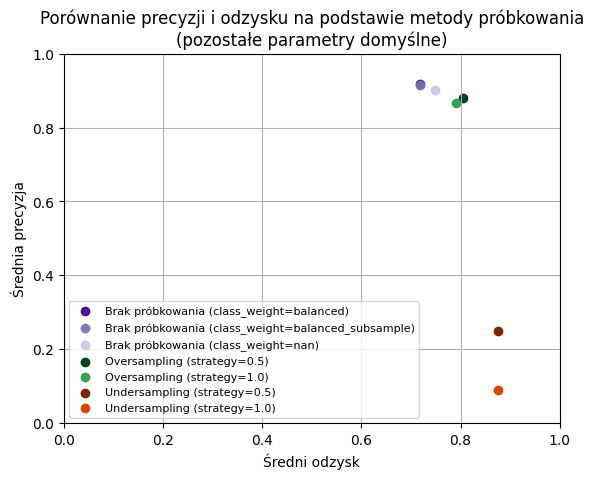

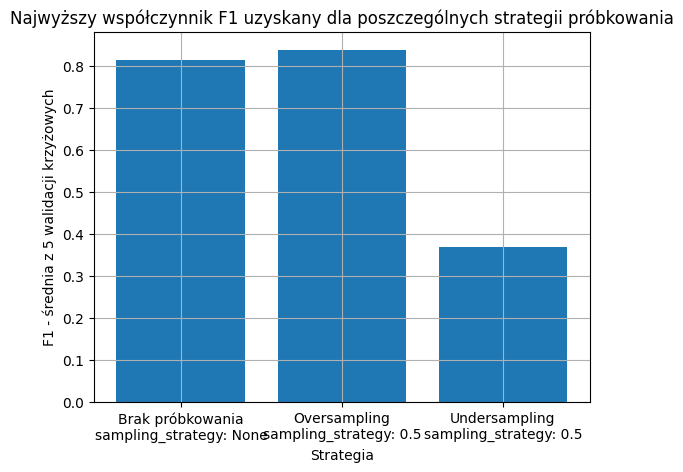

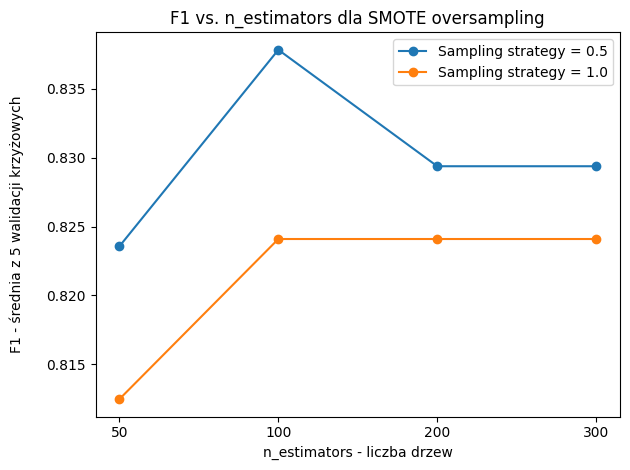

In [ ]:


def get_cmap_iterator(n, color_name):
    cmap = plt.cm.get_cmap(color_name, n)
    list = [matplotlib.colors.to_hex(cmap(i)) for i in range(n)]
    return iter(reversed(list))


def draw_plots(results: pd.DataFrame):
    results.replace({np.nan: None}, inplace=True)

    draw_recall_precision_plot(results)
    print("\n")
    draw_best_f1_plot(results)
    print("\n")
    draw_n_estimators_plot(results)
    print("\n")


def draw_n_estimators_plot(results: pd.DataFrame):
    overs = results[(results["sampling"] == "SamplingMethod.OVER") & (results["param"] == "n_estimators")]

    plt.figure()

    for val, group in overs.groupby("sampling_strategy"):
        plt.plot(group["value"], group["mean_f1"], label=f"Sampling strategy = {val}", marker="o")

    plt.xlabel("n_estimators - liczba drzew")
    plt.ylabel("F1 - średnia z 5 walidacji krzyżowych\n")
    plt.title("F1 vs. n_estimators dla SMOTE oversampling")
    plt.tight_layout()
    plt.legend()
    plt.show()


def draw_recall_precision_plot(results: pd.DataFrame):
    filtered_results = results[(results["value"] == "100") | (results["param"] == "class_weight")]

    cmaps = [get_cmap_iterator(4, 'Purples'),
             get_cmap_iterator(5, 'Oranges'), get_cmap_iterator(4, 'Greens')]

    for sampling_method, group_sm in filtered_results.groupby("sampling"):
        sampling_strategy = SamplingMethod.from_string(sampling_method)
        if sampling_strategy == SamplingMethod.NONE:
            for value, group_val in group_sm[group_sm["param"] == "class_weight"].groupby("value", dropna=False):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_val["mean_recall"], group_val["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (class_weight={value})", color=color, alpha=0.9)
        else:
            for strategy, group_strat in group_sm.groupby("sampling_strategy"):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_strat["mean_recall"], group_strat["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (strategy={strategy})", color=color)

    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.xlabel("Średni odzysk")
    plt.ylabel("Średnia precyzja")
    plt.title("Porównanie precyzji i odzysku na podstawie metody próbkowania\n(pozostałe parametry domyślne)")
    plt.grid(True)
    plt.legend(loc="lower left", prop={'size': 8})
    plt.rcParams["figure.figsize"] = [6.4, 4.8]
    plt.rcParams["figure.figsize"] = (30, 30)
    plt.show()
    plt.style.use('default')



def draw_best_f1_plot(results: pd.DataFrame):
    names = []
    values = []
    best_f1_ids = results.groupby("sampling")["mean_f1"].idxmax()
    for id in best_f1_ids:
        entry = results.iloc[id]
        names.append(
            f"{SamplingMethod.from_string(entry['sampling']).to_string()}\nsampling_strategy: {entry['sampling_strategy']}")
        values.append(entry["mean_f1"])

        # Put this entry into plot

    plt.bar(names, values)
    plt.title('Najwyższy współczynnik F1 uzyskany dla poszczególnych strategii próbkowania')
    plt.xlabel("Strategia")
    plt.ylabel('F1 - średnia z 5 walidacji krzyżowych')
    plt.grid(True)
    plt.show()


def prepare_plots(df: pd.DataFrame):
    for param in df["param"].unique():
        plot_param(df, param)


def plot_param(results, param_name):
    subset = results[results["param"] == param_name].copy()
    sampling_methods = subset["sampling"].unique()

    # Map values to strings for categorical x-axis if needed
    subset["value_str"] = subset["value"].astype(str)

    # Build plot
    plt.figure(figsize=(6, 4))
    for sm in sampling_methods:
        sm_data = subset[subset["sampling"] == sm]
        x = sm_data["value_str"]
        y = sm_data["mean_avg_precision"]
        yerr = sm_data["std_avg_precision"]
        plt.errorbar(x, y, yerr=yerr, marker="o", label=sm, capsize=5)

    plt.title(f"{param_name} vs Average Precision")
    plt.xlabel(param_name)
    plt.ylabel("Mean AP")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Sampling")
    plt.tight_layout()
    plt.show()


df = pd.read_csv("Results/results-random_forest.csv",sep="\t", index_col=0)
draw_plots(df)




### Porównanie precyzji i odzysku
Na wykresie pokazano 3 metody samplingu:
- Brak próbkowania
- undersampling
- oversampling

Celem było wykrycie, która metoda najlepiej sprawdzi się w testowanym algorytmie.
Dla tego porównania pozostałe parametry pozostawiono domyślne.
Na wykresie widać, że najlepszy odzysk (~0.85) uzyskał undersampling. Jest to
jednak obarczone bardzo niską precyzją (nawet poniżej 0.2).

Z pierwszego wykresu, który pokazuje precyzję i odzysk dla różnych metod samplingu
wynika, że najlepsz

In [ ]:

best_params = {
    "random_state": SEED,
    "n_jobs": -1,
    "n_estimators": 100,
    "max_features": "sqrt",
    "class_weight": None,
}


train_full(train_df, test_df,best_params,build_random_forest_model,  "random_forest", SamplingMethod.OVER, sampling_strategy=1.0)

TODO: Wykresy maja byc wygenerowane w python

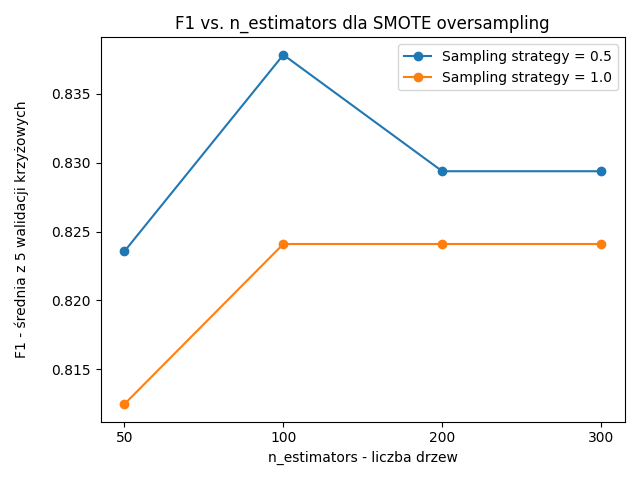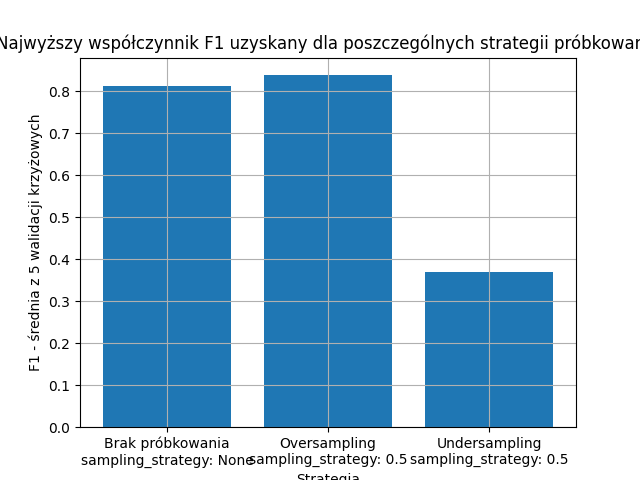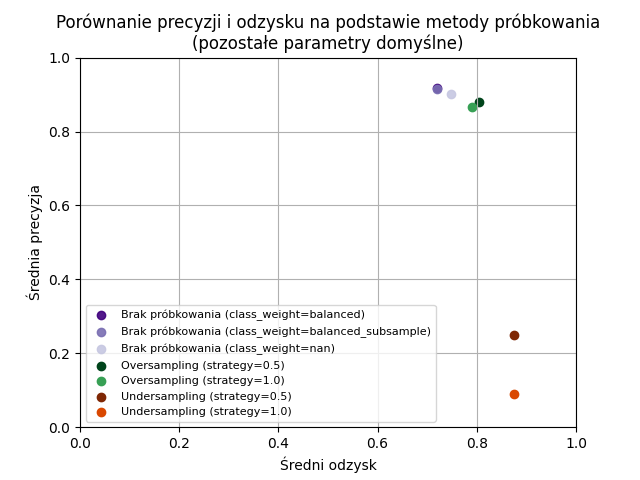

Ostateczne pamaetry modelu dla najlepszych parametrów - do testów uzyto 20% zbioru ktory nie był używany w trakcie procesu

   Precision    Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.961538  0.852273  0.903614        0.891871                0.897822






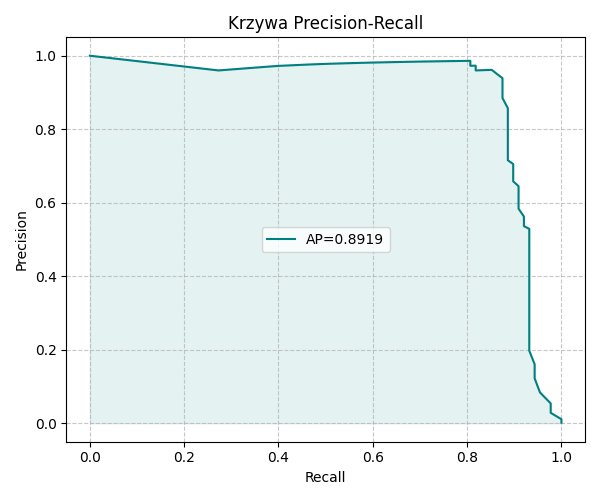

### Drzewo decyzyjne z wagami klas







### XG Boost

## Metody nienadzorowane

### One-Class SVM

Tutaj na razie wstępny wywołanie, żeby zobaczyć czy mniej więcej działa metoda do oceny jakości modelu.

In [ ]:
from sklearn.svm import OneClassSVM

if QUICK_MODE:
  oc_svm_params_to_test = [
        ParameterToTest(name="kernel", values=['linear', 'rbf']),
        ParameterToTest(name="nu", values=[0.01, 0.1, 0.2]),
        ParameterToTest(name="gamma", values=['scale', 'auto'], required_params={"kernel": 'rbf'}),
    ]

  oc_svm_sampling_method_to_test = [
    SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
    SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
    SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
  ]
else:
  oc_svm_params_to_test = [
        ParameterToTest(name="kernel", values=['linear', 'rbf']),
        ParameterToTest(name="nu", values=[0.01, 0.05, 0.1, 0.2]),
        ParameterToTest(name="gamma", values=['scale', 'auto', 0.01, 0.1, 1.0], required_params={"kernel": 'rbf'}),
    ]

  oc_svm_sampling_method_to_test = [
        SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=0.5,
                             data_splits=undersampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=0.5,
                             data_splits=oversampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
    ]

def build_model_function(**kwargs):
    return OneClassSVM(**kwargs)

params_tune_results = params_tune(oc_svm_params_to_test, sampling_methods_to_test=oc_svm_sampling_method_to_test,
            build_model_function=build_model_function, model_name='oc_svm')
print(params_tune_results.describe())


(00:00:52) Fold 1. Main param: kernel=linear. All params: {'kernel': 'linear'}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.001052     0.3  0.002097        0.009293                0.007904
(00:00:56) Fold 2. Main param: kernel=linear. All params: {'kernel': 'linear'}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.002464     0.7  0.004911        0.002836                0.002187
(00:00:58) Fold 1. Main param: kernel=rbf. All params: {'kernel': 'rbf'}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.003559     1.0  0.007092        0.000977                0.000887
(00:01:03) Fold 2. Main param: kernel=rbf. All params: {'kernel': 'rbf'}.
Sampling method Samp

### Las izolacyjny

In [ ]:
# Parametry do badania
n_estimators = [50, 100, 200, 300]
max_samples = ['auto', 128, 256, 512]
contamination = [0.0001, 0.001, 0.005, 0.01]

### Lokalny czynnik odstający

In [ ]:
# Parametry do badania
n_neighbors = [5, 10, 20, 35, 50]
contamination = [0.0001, 0.001, 0.005, 0.01]

### DBSCAN


In [ ]:
# Parametry do badania
eps = [0.5, 1.0, 1.5, 2.0, 3.0]
min_samples = [10, 20, 50, 100]